# Attribution Demo Case 14: UsingRegionInsteadofCountryClassification

## Environment setup

In [1]:
import sys
sys.path.append("../src/")

## Basic configuration

In [2]:
from attribution.common.constants import wq
from attribution.attribution_core import (
    data_query, filtered_by_in, portfolio_weights_regularization
)
from attribution.axioma_utils import axioma_etf_add_consti_weight

from attribution.attribution_class import AttributionGlobal, AttributionResult

2020-08-04 20:39:04,705 - lquantPy.LQuant - INFO - Initial LQuant. This may take some time...
2020-08-04 20:39:04,708 - lquantPy.LQuant - INFO - Initialized LQuant environment
2020-08-04 20:39:04,709 - lquantPy.LQuant - INFO - Initializing LQuant, This will take some time....


Library Path -Djava.library.path=/usr/local/lib/R/site-library/rJava/jri


In [3]:
sample_config = {
    "factor_universe": "CIQMSCI_379978898__OR__Merrion_20200313_v2",
    "factor_universe_name": "MSCI World",
    "port_id": "Merrion_20200313_v2",
    "port_name": "Merrion",
    "weight_tag": "WEIGHT",
    "style_factors": [
        "EPSYLD_LTM_B", "RTN_12M1M", "ES_EPS_NTM_R3M", "FCFYLD",
        "ROE", "REAL_VOL", "MKTCAP", "DIVYLD_TRL", "BOOKP",
        "GR_INTR_EPS", "GR_EXP_5Y_EPS", "DX_UTILIZATION",
        "QES_MACROBETA2_WTI_TR", "QES_SIRC_LEV", "QES_MACROBETA2_HY_SPREADS"
    ],
    "style_factor_names": [
        "Earnings Yld", "Momentum (12M-1M)", "Revision", "Free Cashflow Yld",
        "Profitability", "Volatility", "Size (MktCap)", "Dividend Yld", "Book To Market",
        "EPS Growth (YoY)", "EPS Exp Growth(5Y)", "Short Interest",
        "Oil Beta", "Interest Rate", "High Yield Spread"
    ],
    "base_dir": "/mnt/ebs1/data/hwei/attribution/test/20200731",
}

## Get Portofolio Weight Matrix
- Raw data from data_query function
- market value from filtered_by_in function
- portofolio weight matrix from portfolio_weights_regularization function

In [4]:
def get_portfolio_date_list(port_id):
    var_name = "tmp"
    r_cmd = "{} <- wq.port.get(id = '{}')$dates()".format(var_name, port_id)
    wq.env().run(r_cmd)
    date_list = wq.env().get(var_name).as_string_array()
    wq.env().run("rm({})".format(var_name))
    return date_list

In [5]:
portfolio_date_list = get_portfolio_date_list(port_id=sample_config["port_id"])
print("Portfolio[{}], Start[{}], End[{}]".format(sample_config["port_id"], portfolio_date_list[0], portfolio_date_list[-1]))

Portfolio[Merrion_20200313_v2], Start[2019-01-04], End[2020-02-28]


In [6]:
raw_data = data_query(
    universe_name=sample_config["port_id"],
    date_list=portfolio_date_list,
    factor_list=[
        "IN_{}".format(sample_config["port_id"]),
        "{}_{}".format(sample_config["port_id"], sample_config["weight_tag"]),
        "SEDOL"
    ],
    s_date=None, e_date=None, freq=None, weekdays_only=False,
    local_mode=False, stocks=False, region=False
)

In [7]:
raw_data["IN_{}".format(sample_config["port_id"])].head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
018872.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
012141.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
007647.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
009899.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
014590.02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [8]:
raw_data["{}_{}".format(sample_config["port_id"], sample_config["weight_tag"])].head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
018872.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
012141.01,3.35,3.26,3.33,3.30,3.14,3.25,3.26,3.30,3.35,3.39,...,4.48,4.45,4.59,4.65,4.61,4.84,5.07,5.01,5.05,5.05
007647.01,1.56,1.54,1.92,1.93,1.84,1.85,1.86,1.83,1.85,1.86,...,2.74,2.68,2.70,2.64,2.57,2.55,2.61,2.58,2.66,2.43
009899.01,0.00,0.00,0.54,0.53,0.51,0.51,0.52,0.52,0.52,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
014590.02,0.47,0.49,0.51,0.46,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [9]:
raw_data["SEDOL"].head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
018872.01,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,...,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866,BFLR866
012141.01,2588173,2588173,2588173,2588173,2588173,2588173,2588173,2588173,2588173,2588173,...,2588173,2588173,2588173,2588173,2588173,2588173,2588173,2588173,2588173,2588173
007647.01,2295677,2295677,2295677,2295677,2295677,2295677,2295677,2295677,2295677,2295677,...,2295677,2295677,2295677,2295677,2295677,2295677,2295677,2295677,2295677,2295677
009899.01,2831811,2831811,2831811,2831811,2831811,2831811,2831811,2831811,2831811,2831811,...,2831811,2831811,2831811,2831811,2831811,2831811,2831811,2831811,2831811,2831811
014590.02,2352118,2352118,2352118,2352118,2352118,2352118,2352118,2352118,2352118,2352118,...,2352118,2352118,2352118,2352118,2352118,2352118,2352118,2352118,2352118,2352118


In [10]:
market_value = filtered_by_in(
    signal_matrix=raw_data["{}_{}".format(sample_config["port_id"], sample_config["weight_tag"])],
    in_matrix=raw_data["IN_{}".format(sample_config["port_id"])]
)

In [11]:
market_value.head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
018872.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
012141.01,3.35,3.26,3.33,3.30,3.14,3.25,3.26,3.30,3.35,3.39,...,4.48,4.45,4.59,4.65,4.61,4.84,5.07,5.01,5.05,5.05
007647.01,1.56,1.54,1.92,1.93,1.84,1.85,1.86,1.83,1.85,1.86,...,2.74,2.68,2.70,2.64,2.57,2.55,2.61,2.58,2.66,2.43
009899.01,0.00,0.00,0.54,0.53,0.51,0.51,0.52,0.52,0.52,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
014590.02,0.47,0.49,0.51,0.46,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
portfolio_weight = portfolio_weights_regularization(
    portfolio=market_value, method="long_only"
)

In [13]:
portfolio_weight.head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
018872.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
012141.01,0.029601,0.028844,0.029025,0.029554,0.028111,0.030093,0.029330,0.030462,0.030311,0.030684,...,0.037969,0.038716,0.039154,0.039480,0.041029,0.043292,0.044622,0.048233,0.046335,0.043307
007647.01,0.013785,0.013626,0.016735,0.017285,0.016473,0.017130,0.016734,0.016893,0.016739,0.016836,...,0.023222,0.023317,0.023032,0.022415,0.022873,0.022809,0.022971,0.024839,0.024406,0.020839
009899.01,0.000000,0.000000,0.004707,0.004747,0.004566,0.004722,0.004678,0.004800,0.004705,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
014590.02,0.004153,0.004336,0.004445,0.004120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


- NOTE, this step takes long time to complete ... Persist for future using ...

In [14]:
portfolio_weight_with_etf = axioma_etf_add_consti_weight(
    port_weight_matrix=portfolio_weight, id_matrix=raw_data["SEDOL"],
    etf_comp_model="Composite-ETF-WW", axioma_dir="/mnt/ebs2/axioma-daily-flat/", consti_model="AXWW21-MH", id_type="SEDOL",
    recursive=True, multi_country=True
)

In [15]:
portfolio_weight_with_etf.head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
001045.04,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
001075.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
001078.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
001161.01,0.0,0.0,0.0,0.0,0.0,0.002222,0.002159,0.002215,0.002172,0.002082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004545
001209.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [16]:
import joblib

In [17]:
def load_obj_from_local_file(file_path):
    """
    Load python object from local file
    Params:
        file_path: full path of file in string
    """
    obj = joblib.load(filename=file_path)
    return obj

def dump_obj_list_to_local_file(obj, file_path):
    """
    Dump python object to local file
    Params:
        obj: any python object
        file_path: full path of file in string
    """
    joblib.dump(
        value=obj, filename=file_path, compress=3
    )

In [18]:
dump_obj_list_to_local_file(obj=portfolio_weight_with_etf, file_path="./CASE14-portfolio_weight_with_etf.pickle")

In [19]:
del portfolio_weight_with_etf

In [20]:
portfolio_weight_with_etf = load_obj_from_local_file(file_path="./CASE14-portfolio_weight_with_etf.pickle")

In [21]:
portfolio_weight_with_etf.head()

,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,...,2019-12-31,2020-01-03,2020-01-10,2020-01-17,2020-01-24,2020-01-31,2020-02-07,2020-02-14,2020-02-21,2020-02-28
001045.04,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
001075.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
001078.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
001161.01,0.0,0.0,0.0,0.0,0.0,0.002222,0.002159,0.002215,0.002172,0.002082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004545
001209.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Attribution class, CASE14, UsingRegionInsteadofCountryClassification
- Setup inputs and configurations
- Calculate
- Persist
- Get raw output data from calculation results
- Generate figures and PDF files

In [22]:
!rm -rf {sample_config["base_dir"]}
!mkdir -p {sample_config["base_dir"]}

In [23]:
attr_cls = AttributionGlobal()
attr_cls = attr_cls.set_output_dir(output_dir=sample_config["base_dir"])
attr_cls = attr_cls.set_output_file_name_prefix(file_name_prefix=sample_config["port_id"])
attr_cls = attr_cls.set_portfolio_matrix(portfolio_matrix=portfolio_weight_with_etf)
attr_cls = attr_cls.run_with_daily_performance(run_daily=True)
attr_cls = attr_cls.set_sector_split_regex(
    patterns=["^(?!35)([0-9]{2})[0-9]{6}$", "^([0-9]{4})[0-9]{4}$"],
    replacements=["\\\\1", "\\\\1"]
)
attr_cls = attr_cls.set_country_factor(country_factor=["QES_REGION"])
#attr_cls = attr_cls.addExteriorFactorsQueryFunc(extraFactorQuery, exteriorFactors = 'QES_REGION')
attr_cls = attr_cls.set_country_name_conv(
    conv_map={
        "US": "United States", "CA": "Canada", "EU": "Europe",
        "AXJ": "Asia ex Japan", "JP": "Japan",
        "GB": "United Kindom", "ANZ": "Australia",
    }
)
attr_cls = attr_cls.load_axioma_idio_risk(load=True)
attr_cls = attr_cls.set_fmp_universe(
    fmp_universe=sample_config["factor_universe"],
    universe_id=True,
    universe_name=sample_config["factor_universe_name"]
)
attr_cls = attr_cls.set_fmp_include_holding(include=False)
attr_cls = attr_cls.set_benchmark(
    benchmark={"MSCI World": "CIQMSCI_379978898"},
    benchmark_weight_tag="CIQ_MSCI_FLOAT",
    benchmark_id=True
)
attr_cls = attr_cls.set_style_factors(
    style_factors=sample_config["style_factors"],
    style_factor_names=sample_config["style_factor_names"]
)

rAttribution <- Attribution$new()
rAttributionGlobal <- AttributionGlobal$new()
rAttributionGlobal <- rAttributionGlobal$setOutputDir(outputDir = '/mnt/ebs1/data/hwei/attribution/test/20200731')
rAttributionGlobal <- rAttributionGlobal$setOutputFileNamePrefix(fileNamePrefix = 'Merrion_20200313_v2', timeStamp = 'u%Y%m%d')
rAttributionGlobal <- rAttributionGlobal$setPortfolioMatrix(portfolioMatrix = pMat)
rm(pMat)
rAttributionGlobal <- rAttributionGlobal$runWithDailyPerformance(runDaily = TRUE)
rAttributionGlobal <- rAttributionGlobal$setSectorSplitRegex(patterns = c('^(?!35)([0-9]{2})[0-9]{6}$', '^([0-9]{4})[0-9]{4}$'), replacements = c('\\1', '\\1'))
rAttributionGlobal <- rAttributionGlobal$setCountryFactor(countryFactor = c('QES_REGION'))
rAttributionGlobal <- rAttributionGlobal$setCountryNameConv(convMap = c('GB' = 'United Kindom', 'EU' = 'Europe', 'ANZ' = 'Australia', 'US' = 'United States', 'AXJ' = 'Asia ex Japan', 'CA' = 'Canada', 'JP' = 'Japan'))
rAttributionGlobal <- rAttributio

- Note, the calculation method will take relatively long to complete ...
- Therefore, usually it would be good to persist this for future use ...

In [15]:
attr_cls = attr_cls.calculate()

rAttribution <- rAttribution$calculate()


In [16]:
attr_cls.persist_class()

save(rAttribution, file = "rAttribution.RData")


In [17]:
!ls ./*.RData

./rAttribution.RData


- Get raw output data as a nested dictionary of dataframes from Attribution class

In [18]:
attr_raw_output_data = attr_cls.get_output_raw()

res <- rAttribution$getOutputRaw()
rm(res)


In [19]:
sorted(
    attr_raw_output_data.keys(),
    key=str.lower
)

['AttributionSummary',
 'AttributionSummary_PIT',
 'Bias Stat',
 'BrSum',
 'Concentration Analysis',
 'Correlation',
 'coverage',
 'Cum Portfolio Return Contribution',
 'Cum Residual Return Contribution',
 'Cum Return after Adv Cut',
 'Cum Return after Delta Adv Cut',
 'Cum Return Contribution',
 'Cum SecRetAlloc Contribution',
 'Cum StyleRetAlloc Contribution',
 'Cum StyleRetSelec Contribution',
 'dailyCumReturnContri',
 'dailyReturnContri_plain',
 'Delta Port Adj ADV Perc',
 'Exposure (Vol Adj)',
 'Factor Decile',
 'Factor Exposure',
 'Factor Gross Size',
 'Factor Score',
 'FMP Cum Return',
 'FMP Return',
 'fmpDailyCumReturns',
 'fmpDailyReturns',
 'Gross Wgt By Sec',
 'ICs',
 'Low Weight Cut_NUM',
 'Low Weight Cut_PERC',
 'Low Weight CutCUM_RETURN',
 'Low Weight CutRETURN',
 'LSreturns',
 'Net Wgt By Sec',
 'Port Adj ADV Perc',
 'Port Turnover',
 'Portfolio Turnover',
 'portfolio_smooth_CUM_RETURN',
 'portfolio_smooth_RETURN',
 'portfolio_smooth_TURNOVER',
 'Post Cut Residual_NUM',


In [20]:
attr_raw_output_data["AttributionSummary"].head()

,Factor Exposure,Factor Decile,Exposure (Vol Adj),Correlation,Risk Contribution,Risk Contribution(%),Return Contribution
Earnings Yld,0.310860,6.660714,0.005490,0.064774,0.000854,0.011256,0.001262
Momentum (12M-1M),0.729601,8.017857,0.015356,0.200839,0.004810,0.081538,0.007654
Revision,0.472183,7.151786,0.004230,0.001051,0.000241,0.005040,0.001721
Profitability,0.829700,8.383929,0.016325,0.039721,0.000566,0.014266,-0.009172
Volatility,-0.371438,4.062500,-0.018907,-0.366855,0.009191,0.140506,-0.000792


- Dump excel output

In [21]:
attr_cls = attr_cls.output_excel()

rAttribution <- rAttribution$outputExcel()


In [22]:
!ls {sample_config["base_dir"]}/data

FS_Event_US_u20200727_SummaryAndTS_20200727085717.xlsx


- Dump png output

In [23]:
attr_cls = attr_cls.output_charts()
attr_cls = attr_cls.output_pit_charts()

rAttribution <- rAttribution$outputCharts()
rAttribution <- rAttribution$outputPITCharts()


In [24]:
!ls -R {sample_config["base_dir"]}/charts

/mnt/ebs1/data/hwei/attribution/test/20200719/charts:
FS_Event_US_u20200727  FS_Event_US_u20200727_PIT

/mnt/ebs1/data/hwei/attribution/test/20200719/charts/FS_Event_US_u20200727:
0_1_summaryTable.png
0_2_residualTable.png
10_ReturnContri_Sectors.png
11_Performance_Sectors.png
12_1_ReturnContribution_Residuals.png
12_CumReturns_Residuals.png
13_Risk_vs_Return_Styles.png
14_Risk_vs_Return_Sectors.png
17_10_Communication_Sectors_Exp_vs_Return.png
17_11_Utilities_Sectors_Exp_vs_Return.png
17_12_Real Estate_Sectors_Exp_vs_Return.png
17_1_Energy_Sectors_Exp_vs_Return.png
17_2_Materials_Sectors_Exp_vs_Return.png
17_3_Industrials_Sectors_Exp_vs_Return.png
17_4_Con Discretionary_Sectors_Exp_vs_Return.png
17_5_Con Staples_Sectors_Exp_vs_Return.png
17_6_HealthCare E&S_Sectors_Exp_vs_Return.png
17_7_Pharm&Bio_Sectors_Exp_vs_Return.png
17_8_Financials_Sectors_Exp_vs_Return.png
17_9_Info Tech_Sectors_Exp_vs_Return.png
18_1_10_Communication_Alloc_Decomp_Sectors.png
18_1_11_Utilities_Alloc_Decomp_Sec

- Dump pdf output

In [25]:
attr_cls = attr_cls.set_pdf_title(
    title="{} Portfolio Historical Attribution".format(sample_config["port_name"])
)
attr_cls = attr_cls.set_pdf_title_pit(
    title="{} Portfolio Attribution Point-In-Time".format(sample_config["port_name"])
)
attr_cls = attr_cls.generate_historical_pdf()
attr_cls = attr_cls.generate_pit_pdf()

rAttribution <- rAttribution$setPDFTitle(title = 'FS Event Portfolio Historical Attribution')
rAttribution <- rAttribution$setPDFTitle_PIT(title = 'FS Event Portfolio Attribution Point-In-Time')
rAttribution <- rAttribution$generateHistoricalPDF()
rAttribution <- rAttribution$generatePITPDF()


In [26]:
!ls {sample_config["base_dir"]}/*.pdf

/mnt/ebs1/data/hwei/attribution/test/20200719/FS_Event_US_u20200727_Historical.pdf
/mnt/ebs1/data/hwei/attribution/test/20200719/FS_Event_US_u20200727_PIT.pdf


In [27]:
del attr_cls

rm(rAttribution)


## Visualization

- Heatmap, for example, AttributionSummary
- Time series, for example, Cum Portfolio Return Contribution
- Table, for example, Summary

- Create new class from persisted class

In [28]:
attr_cls = Attribution.load_from_local_file(
    file_path="./rAttribution.RData", obj_name="rAttribution"
)

rAttribution <- Attribution$new()
rm(rAttribution)
load(file = "./rAttribution.RData")


In [29]:
attr_raw_output_data = attr_cls.get_output_raw()

res <- rAttribution$getOutputRaw()
rm(res)


In [30]:
del attr_cls

rm(rAttribution)


In [31]:
%matplotlib inline

In [32]:
attr_res_cls = AttributionResult(attr_raw_output_data)

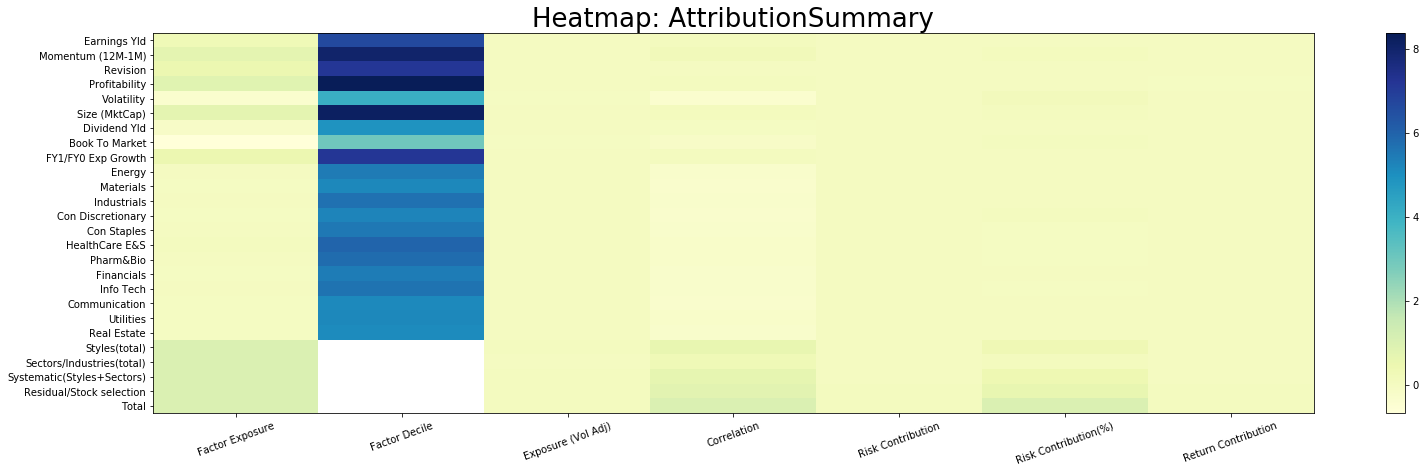

In [33]:
fig = attr_res_cls.plot_attribution_summary()

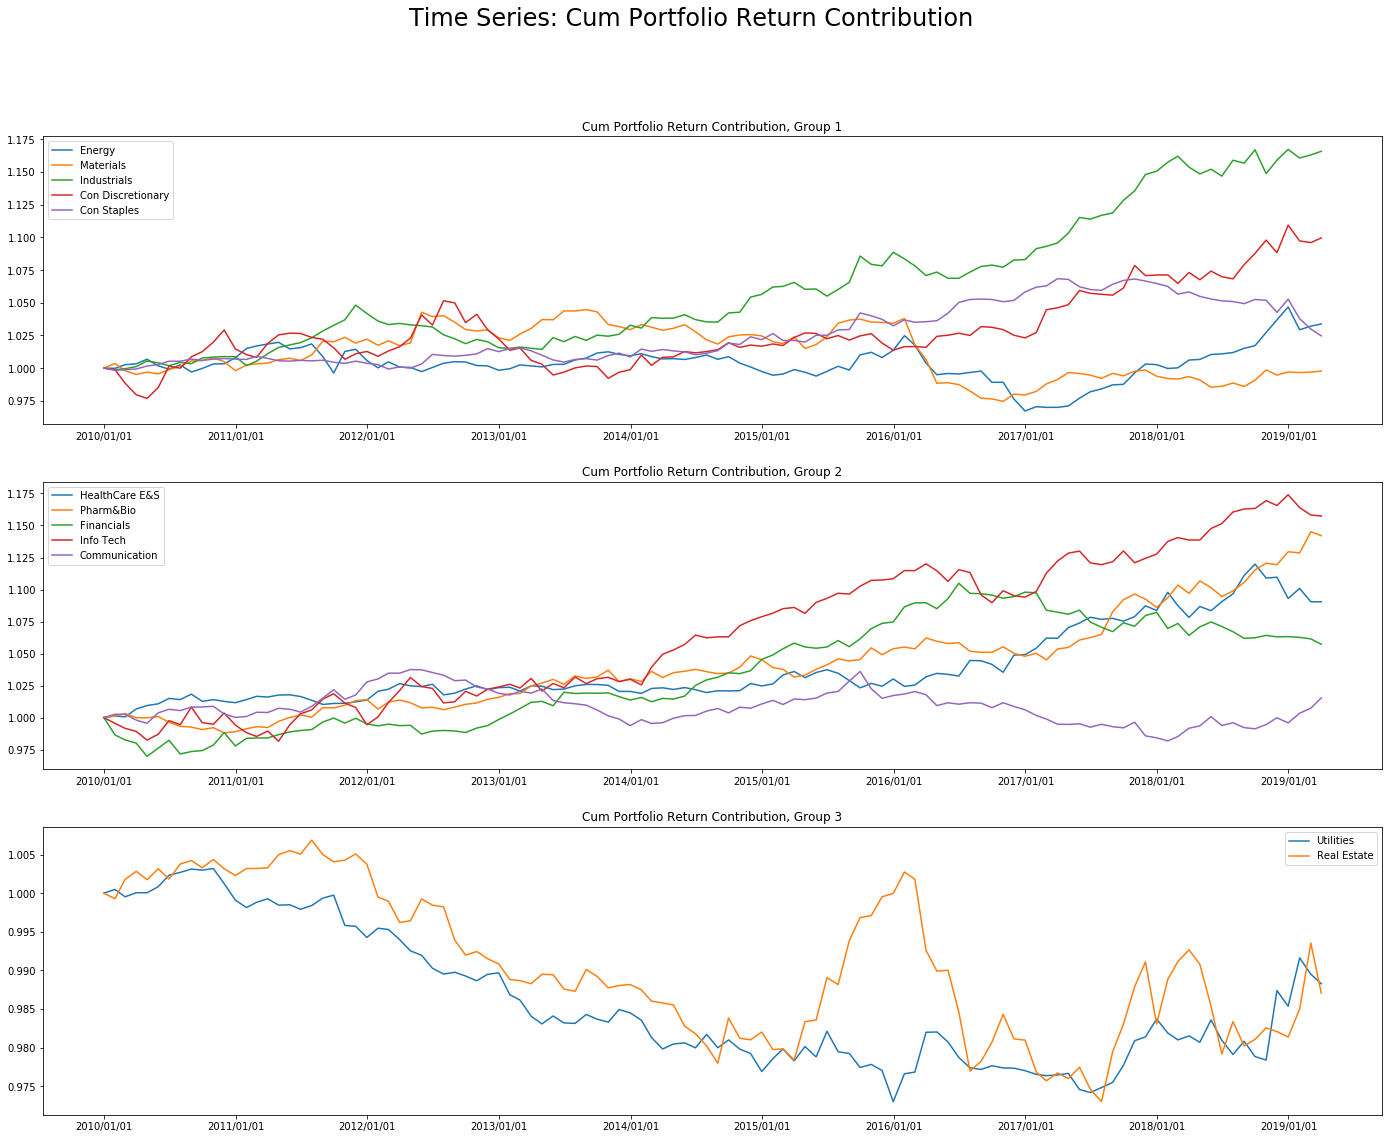

In [34]:
fig = attr_res_cls.plot_cum_portfolio_return_contribution()

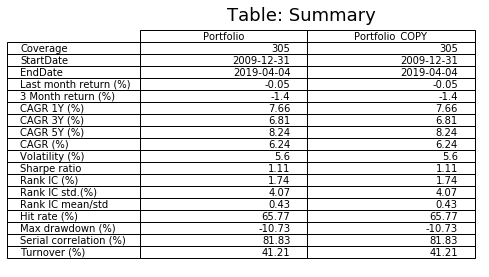

In [35]:
fig = attr_res_cls.plot_summary()

In [36]:
del attr_res_cls

### End of file